In [ ]:
!pip install s3fs

In [2]:
import s3fs

# Подключение до S3
fs = s3fs.S3FileSystem(key="oGG7onz8X7dfT_AKvwKn",
                       secret="YT74LUkrzipAFWcBmHuBOszIxwdLFtjNPkxkVV4O",
                       client_kwargs={'endpoint_url': "http://storage.yandexcloud.net"})

with fs.open(f"nlp-test-task/data.csv", "rb") as remote_file:
    # Скачает датасет в файл data.csv 
    with open("data.csv", "wb") as local_file:
        local_file.write(remote_file.read())

In [3]:
import pandas as pd

df = pd.read_csv("data.csv")

In [4]:
df.head()

,Unnamed: 0,title,description
0,30330,Анальная пробка,"<p><img src=""https://image-cdn.kazanexpress.ru..."
1,8969,"Happy Jungle, минеральный камень для птиц с во...","<p><span style=""color: rgb(51, 51, 51);"">Полез..."
2,8100,Яркие объемные 3d Бабочки на магните,"<h2 class=""ql-align-center"">Яркие объемные 3d ..."
3,35149,Классический бюстгальтер с пуш-апом,"<p><img src=""https://image-cdn.kazanexpress.ru..."
4,8913,Защитное стекло iPhone 5/5S/SE Черное | 10D с ...,<p>Защитное стекло для дисплея вашего apple га...


In [5]:
from bs4 import BeautifulSoup

def clean(html):
    soup = BeautifulSoup(str(html), 'html')
    return soup.text

In [6]:
df['description_clean'] = df['description'].apply(clean)

In [7]:
df.head()

,Unnamed: 0,title,description,description_clean
0,30330,Анальная пробка,"<p><img src=""https://image-cdn.kazanexpress.ru...",**********************************************...
1,8969,"Happy Jungle, минеральный камень для птиц с во...","<p><span style=""color: rgb(51, 51, 51);"">Полез...",Полезное и вкусное дополнение к ежедневному ко...
2,8100,Яркие объемные 3d Бабочки на магните,"<h2 class=""ql-align-center"">Яркие объемные 3d ...","Яркие объемные 3d Бабочки на магните, 12 штук...."
3,35149,Классический бюстгальтер с пуш-апом,"<p><img src=""https://image-cdn.kazanexpress.ru...",
4,8913,Защитное стекло iPhone 5/5S/SE Черное | 10D с ...,<p>Защитное стекло для дисплея вашего apple га...,Защитное стекло для дисплея вашего apple гадже...


###Description len destribution (kinda exponential)

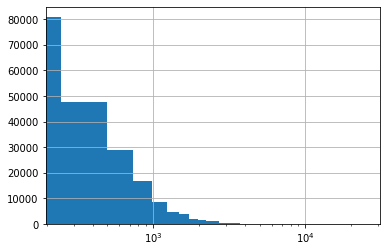

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xscale('log')

df['description_clean'].str.len().hist(bins=100)

###Title len destribution (kinda normal lol)

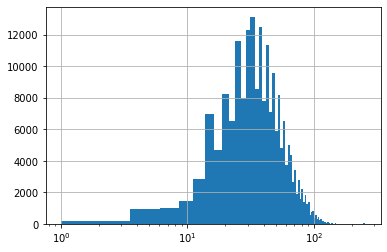

In [11]:
fig, ax = plt.subplots()
ax.set_xscale('log')

df['title'].str.len().hist(bins=100)

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

nltk.download('punkt')
nltk.download('stopwords')


def preprocessing(text: str) -> str:
    text = str(text)
    # tokenize sent
    tokens = nltk.word_tokenize(text)
    # remove non alphabetic words
    words = [word.lower() for word in tokens if word.isalpha()]

    # remove punctuation
    import string
    table = str.maketrans('', '', string.punctuation)
    words = [w.translate(table) for w in words]

    # remove stop words
    stop_words = set(stopwords.words('russian'))
    words = [w for w in words if not w in stop_words]


    # test
    porter = SnowballStemmer("russian")
    stemmed = [porter.stem(word) for word in words]

    return ' '.join(stemmed)

In [13]:
preprocessing('Защитное стекло, iPhone 5/5S/SE Черное | 10D с ..')

'защитн стекл iphon черн'

In [14]:
df_ready = df[["title", "description_clean"]]
df_ready = df_ready.applymap(preprocessing)
df_ready.head()

,title,description_clean
0,анальн пробк,гост наш магазин рад прояв интерес интимн това...
1,happ jungl минеральн камен птиц водоросл г,полезн вкусн дополнен ежедневн корм такж средс...
2,ярк объемн бабочк магн,ярк объемн бабочк магн комплект идут круглешк ...
3,классическ бюстгальтер,
4,защитн стекл iphon черн салфетк стикер копплек...,защитн стекл диспле ваш appl гаджет надежн защ...


In [15]:
df_ready.to_csv('df_ready.csv')

In [42]:
import pandas as pd
df_ready = pd.read_csv("df_ready.csv").dropna()
df_ready

,Unnamed: 0,title,description_clean
0,0,анальн пробк,гост наш магазин рад прояв интерес интимн това...
1,1,happ jungl минеральн камен птиц водоросл г,полезн вкусн дополнен ежедневн корм такж средс...
2,2,ярк объемн бабочк магн,ярк объемн бабочк магн комплект идут круглешк ...
4,4,защитн стекл iphon черн салфетк стикер копплек...,защитн стекл диспле ваш appl гаджет надежн защ...
5,5,крем гиалуронов увлажнен омоложен secret ke hy...,напиш нам чат получ промокод hyaluron aqu soft...
...,...,...,...
199995,199995,защитн стекл glass appl iphon х xr,защитн стекл glass эт сверхпрочн сверхтонк сте...
199996,199996,магнитик,сувенирн магнитик акрилов вид казан
199997,199997,набор тонк сверл шт,набор сверл обработк дерев пластик металл спец...
199998,199998,гибк защитн стекл ceramics appl iphon,уникальн противоударн защитн стекл лицев сторо...


## Предесловие
ембединги получаются путем прогона всех текстов через предобученные модели-трансформеры.



## Prepare inference model V1

In [ ]:
!python3 -m pip install --upgrade pip
# first run with --use-deprecated=legacy-resolver then without :\
!pip3 install --use-deprecated=legacy-resolver deeppavlov 

In [ ]:
!wget https://raw.githubusercontent.com/deepmipt/DeepPavlov/master/deeppavlov/configs/embedder/elmo_ru_wiki.json

In [ ]:
%tensorflow_version 1.x
from deeppavlov import build_model


elmo_model = build_model('elmo_ru_wiki.json', download=True)

In [9]:
elmo_model([['привет мир я елмо', 'лол кек']])[0].__len__()

2

In [43]:
from tqdm import tqdm_notebook

vectors = []
batch = []
batch_size = 128

for index, row in tqdm_notebook(df_ready.iterrows()):
    batch.append([row['title'] + ' ' + row['description_clean']])
    
    if len(batch) == batch_size:

        vectors += elmo_model(batch)
        batch = []


vectors += elmo_model(batch)

len(vectors)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


191018

In [44]:
import numpy as np
vectors = np.array(vectors)
vectors = np.squeeze(vectors, axis=1)

vectors.shape

(191018, 2560)

In [45]:
def get_vector(query:str) -> np.array:
    return elmo_model([[query]])[0].squeeze(axis=0)

## Prepare inference model V2 (launch in separete session fomr V1 (tf incompat))

In [ ]:
!pip install tensorflow_text

In [9]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import tensorflow_text as text 
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

In [11]:
df_ready = df.dropna()

from tqdm import tqdm_notebook

vectors = []
batch = []
batch_size = 128

for index, row in tqdm_notebook(df_ready.iterrows()):
    batch.append([row['title'] + ' ' + row['description_clean']])
    
    if len(batch) == batch_size:

        vectors.append(embed(batch))
        batch = []


vectors.append(embed(batch))
vectors = np.concatenate([i.numpy() for i in vectors], axis=0)

vectors.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


(199991, 512)

In [12]:
def get_vector(query:str) -> np.array:
    return embed([query])[0].numpy()

## Построить векторное представление

In [13]:
def normalization(embeds):
  norms = np.linalg.norm(embeds, 2, axis=1, keepdims=True)
  return embeds/norms

vectors_norm = normalization(vectors)
vectors_norm.shape

(199991, 512)

изначальная идея была использовать `TSNE` но из-за большого количества данных был выбран `TruncatedSVD`, так как он работает быстрее

In [14]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

In [15]:
encoded = TruncatedSVD(n_components=2).fit_transform(vectors_norm)

In [16]:
encoded.shape

(199991, 2)

## Показать проекцию всех товаров, или части товаров, на 2D

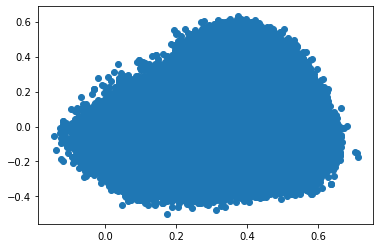

In [18]:
import numpy as np
import matplotlib.pyplot as plt


x = encoded[:,0]
y = encoded[:,1]

plt.scatter(x, y)
plt.show()

## Показать примеры решения задач кластеризации с помощью этих представлений

среди алгоритмов кластеризации был выбран `MiniBatchKMeans` из-за его скорости и возможности создания кластеров в равномерно распределенных данных


In [19]:
from sklearn.cluster import MiniBatchKMeans, KMeans, SpectralClustering
import matplotlib.cm as cm

In [20]:
model = MiniBatchKMeans(20, batch_size=1000)
prediction = model.fit_predict(vectors_norm)

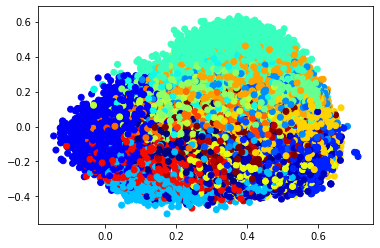

In [21]:
x = encoded[:,0]
y = encoded[:,1]

plt.scatter(x, y, c=prediction, cmap=cm.jet)
plt.show()

## Показать примеры решения задач поиска K ближайших с помощью этих представлений

изначальная идея ембедингов составить скрытое пространство дл япредставления схожести документов как расстояние в этом пространстве. Для задачи поиска в таком пространстве подходящий вариант `NearestNeighbors` для поиска K ближайщих соседей в этом пространстве.

In [22]:
k = 5

In [26]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(vectors_norm)

In [28]:
query = 'свитер'
# query = preprocessing(query)

query_vec = get_vector(query)

distances, indices = nbrs.kneighbors([query_vec])

In [29]:
df_ready.iloc[indices[0]]

,Unnamed: 0,title,description,description_clean
21459,7298,Юбка,"<p class=""ql-align-center""><img src=""https://i...",
187678,16744,Вязаный полосатый свитер,<p>Вязаный полосатый свитер&nbsp;</p>,Вязаный полосатый свитер
17879,17906,Sweet свитер,<p>нежные и уютные свитерочки</p>,нежные и уютные свитерочки
58389,7634,Юбка трикотажная тёплая,<p><br></p>,
48563,606,Жилет,<p>орщшргкео</p>,орщшргкео


In [55]:
from typing import List

def get_5_nearest(query: str) -> List[str]:

    query_vec = get_vector(query)

    distances, indices = nbrs.kneighbors([query_vec])

    result = []
    for i, row in df_ready.iloc[indices[0]].iterrows():

        result.append(row['title'] + ' ' + row['description_clean'])

    return result

In [56]:
query = 'свитер'
get_5_nearest(query)

['Юбка ',
 'Вязаный полосатый свитер Вязаный полосатый свитер\xa0',
 'Sweet свитер нежные и уютные свитерочки',
 'Юбка трикотажная тёплая ',
 'Жилет орщшргкео']